# Heart Disease Classification Project


<div style="text-align:center;">
  <img src="./images/project-image.jpg" alt="Heart" style="height: 310px; display: block; margin: 24px auto;">
</div>

## Introduction

In this Jupyter Notebook project, we will explore and analyze a dataset related to heart disease. Our goal is to build a machine learning model that can predict whether a person has heart disease or not based on various attributes. Heart disease is a critical health condition, and early detection can play a significant role in effective medical intervention.

The dataset used in this project is obtained from [Kaggle](https://www.kaggle.com/datasets/redwankarimsony/heart-disease-data) and includes information about different individuals, including features like age, gender, chest pain type, blood pressure, cholesterol levels, and more.

Our project will involve the following steps:

1. **Data Exploration:** We will begin by loading and examining the dataset to understand its structure, feature types, and data distribution.

2. **Data Preprocessing:** We will handle any missing values, encode categorical variables, and perform necessary transformations to prepare the data for modeling.

3. **Exploratory Data Analysis (EDA):** We will visualize and analyze the relationships between different features and the target variable (presence of heart disease).

4. **Feature Scaling:** Depending on the chosen algorithms, we will decide whether feature scaling is necessary and perform it if needed.

5. **Model Selection:** We will explore various classification algorithms suitable for our problem, such as logistic regression, decision trees, random forests, and support vector machines.

6. **Model Training:** After selecting an appropriate algorithm, we will train our model on the training data.

7. **Model Evaluation:** We will evaluate the model's performance using metrics like accuracy, precision, recall, F1-score, and ROC-AUC on a separate test dataset.

8. **Conclusion:** Based on the evaluation results, we will draw conclusions about the model's effectiveness in predicting heart disease and discuss potential improvements.

In [117]:
# Perform necessary imports

# For Regular EDA (Exploratory Data Analysis) and plotting libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Import xgboost
import xgboost as xgb

# To make the plots appear directly within the notebook interface
%matplotlib inline

# Sklearn imports
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, GridSearchCV, cross_val_predict
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc, make_scorer, confusion_matrix

# For undersampling
# from imblearn.over_sampling import RandomOverSampler
# from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.under_sampling import EditedNearestNeighbours

In [118]:
df = pd.read_csv('data/heart_disease_data.csv')
df.shape

(920, 16)

In [119]:
# We shall print the first 5 records to see what our data looks like
df.head()

,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


In [120]:
# From our dataset, we do need the id and dataset columns. Hence we shall drop them
df = df.drop(['id', 'dataset'], axis=1)

# Also we shall rename the num to target since that is what we are predicting
df.rename(columns={'num': 'target'}, inplace=True)

df.head() # print the dataset after dropping id and dataset

,age,sex,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,target
0,63,Male,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,67,Male,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,67,Male,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,37,Male,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,41,Female,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


In [121]:
# We shall check the bias of the target 
class_counts = df.groupby('target').size()
class_counts

target
0    411
1    265
2    109
3    107
4     28
dtype: int64

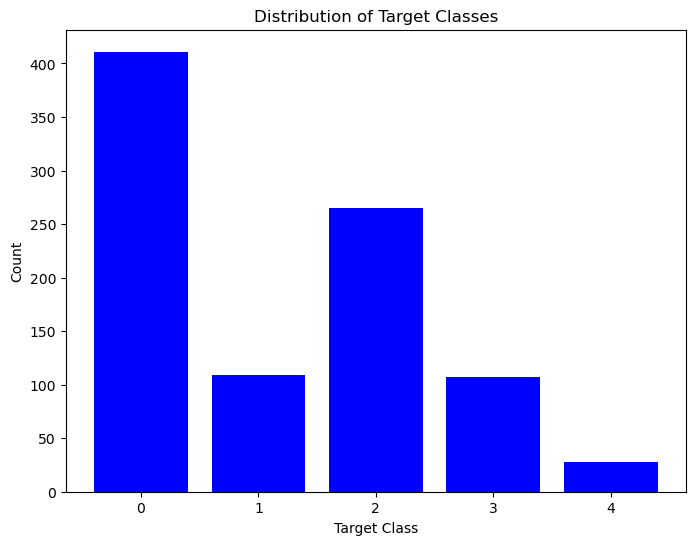

In [122]:
# We shall visualize the above result using a bar chart
classes = df['target'].unique()

plt.figure(figsize=(8, 6))
plt.bar(classes, class_counts, color='blue')
plt.xlabel('Target Class')
plt.ylabel('Count')
plt.title('Distribution of Target Classes')
plt.xticks(classes);

By looking at the above graph, we can deduce the following,
1. **Class Imbalance** - Classes are highly imbalanced. Some classes have significant instances than others
2. **Dominant Classes** - Classes 0 and 1 have highest counts making them the most dominant classes in the dataset
3. **Rare Classes** - Classes 2, 3 and 4 have relatively low counts making them the rare classes in the dataset
4. **Imapct on Model Performance** - Imbalanced datasets can make the model challenging to predict rare classes due
                                     the model having not having enough examples to learn
5. **Evaluation Metrics** - When evaluating the model, the standard accuracy might not be the most reliable metric. We
                            will have to use metrics like Precision, Recall, F1-Score and ROC-AUC
6. **Sampling Techniques** - To increase the frequency of correctly predicting the rare classes, we might have to use
                             sampling techniques like oversampling (increasing the number of instances in rare
                             classes) or undersampling (decreasing the number of instances in dominant classes)

In [123]:
# Split the dataset into Features (X) and Target (Y)
X = df.drop("target", axis=1)
y = df["target"]

In [124]:
# Let us create our train and test split
np.random.seed(42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# In order to not loose a significant amount of records from our dataset, and establishing the fact that predicting
# the minority classes are not as important as predicting the majority classes, we shall perform an oversampling as
# below

# undersampler = RandomUnderSampler()
# X_train, y_train = undersampler.fit_resample(X_train, y_train)

In [125]:
# In our dataset, we shall look for missing data

def get_missing_value_counts(df):
    missing_value_counts = df.isnull().sum()
    return missing_value_counts

get_missing_value_counts(df)

age           0
sex           0
cp            0
trestbps     59
chol         30
fbs          90
restecg       2
thalch       55
exang        55
oldpeak      62
slope       309
ca          611
thal        486
target        0
dtype: int64

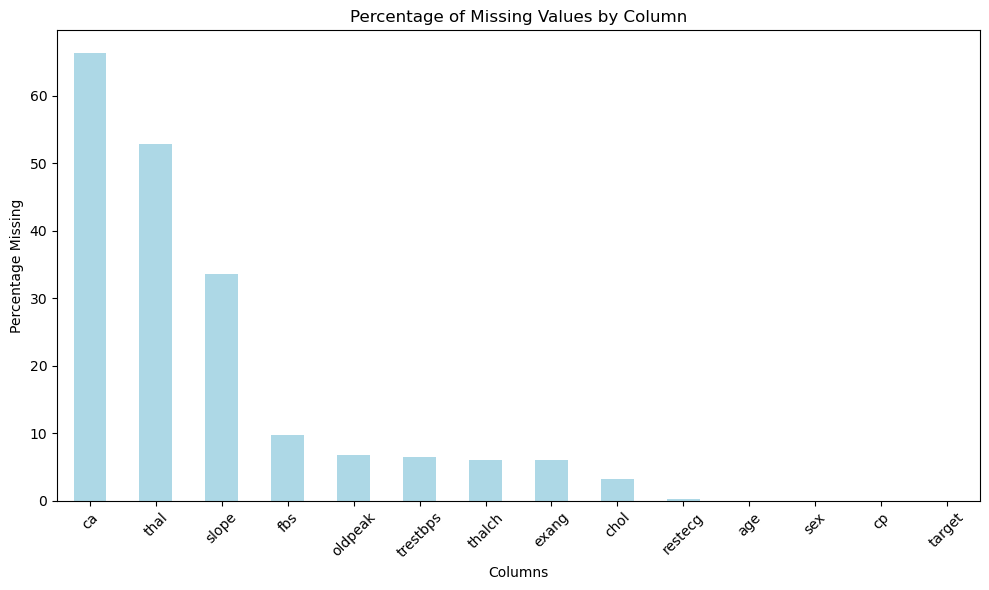

In [126]:
# We shall create a bar chart with missing value percentage for each column we have

missing_value_counts = get_missing_value_counts(df)
missing_value_percentages = (missing_value_counts / len(df)) * 100

plt.figure(figsize=(10, 6))
missing_value_percentages.sort_values(ascending=False).plot(kind='bar', color='lightblue')
plt.title('Percentage of Missing Values by Column')
plt.xlabel('Columns')
plt.ylabel('Percentage Missing')
plt.xticks(rotation=45)
plt.tight_layout();

By looking at the above graph, we can derive the following conclusions,

1. **Column wise missing values** - Majority of the columns in the dataset has a low percentage of missing values
                                    which suggests that we have mostly completed data for these columns
2. **"ca", "thal" and "slope" have high missing values** - A notably high amount of missing values can be observed in
                                                           these columns. We have to provide special attention to                                                                these columns during the data preprocessing stage.
3. **"restecg", "thalch" and "exang" have moderate missing values** - Though these columns show a moderate amount of
                                                                      missing values, appropriate handling of missing
                                                                      values during the preprocessing steps are recomm
                                                                      -ended for building an accurate model.
4. **"trestbps", "chol", "oldpeak" and "fps" have low missing values** - These columns have a low amount of missing values and
                                                              although handling them is advisable, on the overall
                                                              analysis their impact will be minor.
5. **Columns with zero missing values** - Columns "age", "sex", "cp" and target does not have any missing values,
                                          which indicates that we have complete data for these columns

Upon searching on the internet, it was difficult to find a concrete article or a resource that indicates there is a
direct connection between "ca" (number of major vessels (0-3) colored by fluoroscopy) and heart diseases. As a result
we will drop that columns.

However there seems to be a stronger connections between hear diseases and thal and slope as per the following two
articles respectively. Hencne we shall use necessary means to fill the missing data for these two columns.

thal - https://www.mdpi.com/2039-4365/13/1/5#:~:text=Myocardial%20iron%20overload%20is%20a,extreme%20cases%2C%20sudden%20cardiac%20death.

slope - https://www.sciencedirect.com/science/article/abs/pii/0002870386902656#:~:text=The%20ST%20segment%20shift%20relative,coronary%20artery%20disease%20(CAD).

In [127]:
# Drop the ca column
X_train = X_train.drop(columns=['ca'])
X_test = X_test.drop(columns=['ca'])

df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,target
0,63,Male,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,67,Male,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,67,Male,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,37,Male,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,41,Female,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


Now we shall move onto imputing missing values for columns "restecg", "thalch", "exang", "trestbps", "chol" and "fps".
These columns have either a low or moderate amount of missing values. When imputing missing values with either mean,
median or mode, we shall take the following criteria into consideration.

1. **Mean** - Better to be used in scenarios that the data is normally distributed and does not show any outliers
2. **Median** - Better to be used in scenarios where data is not normally distributed or has significant outliers
3. **Mode** - Better to be used in scenarios where we have categorical or descrete data

In [128]:
df.dtypes

age           int64
sex          object
cp           object
trestbps    float64
chol        float64
fbs          object
restecg      object
thalch      float64
exang        object
oldpeak     float64
slope        object
ca          float64
thal         object
target        int64
dtype: object

By observing our data frame, their corresponding data types and the criteria we came up with to decide whether we
should use mean, mode or median for imputing the missing data, we can come to the following conclusion,

1. Since 'restecg', 'exang' and 'fbs' are categorical variables, we shall use mode for imputing them.
2. Since remaining variables we have marked for imputation are continous variables we shall decide whether the mean
   should be used or the median should be used for imputing them with the data distribution

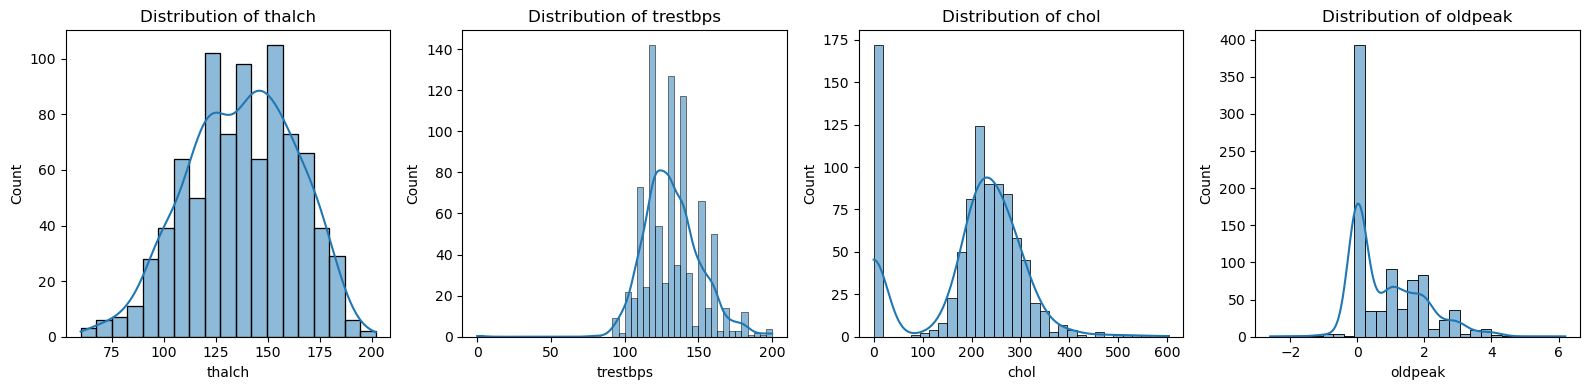

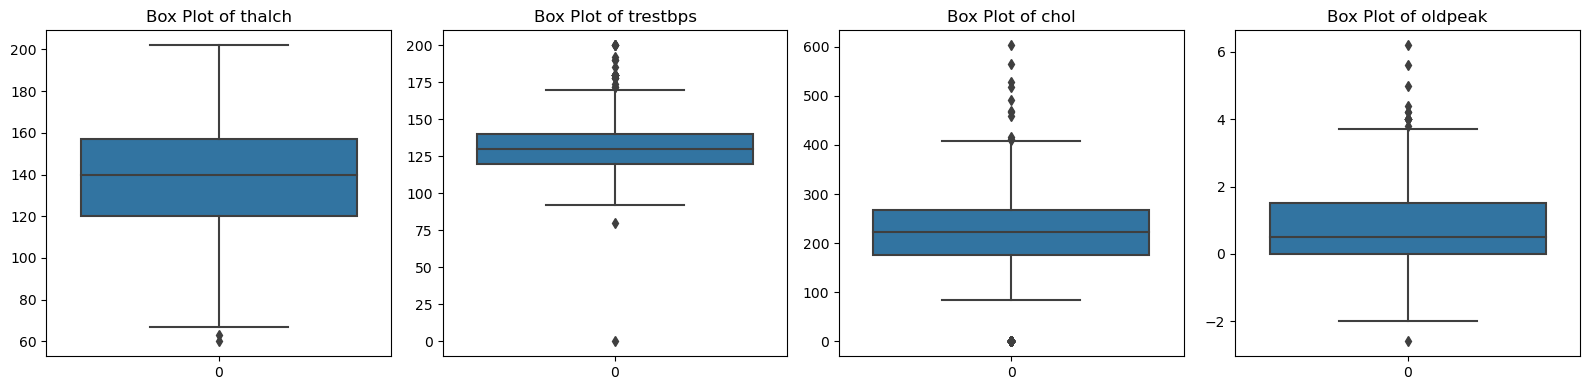

In [129]:
# Visualize the distribution of thalch, trestbps, chol, and oldpeak
plt.figure(figsize=(16, 4))

# Distribution plots
plt.subplot(1, 4, 1)
sns.histplot(df['thalch'], kde=True)
plt.title('Distribution of thalch')

plt.subplot(1, 4, 2)
sns.histplot(df['trestbps'], kde=True)
plt.title('Distribution of trestbps')

plt.subplot(1, 4, 3)
sns.histplot(df['chol'], kde=True)
plt.title('Distribution of chol')

plt.subplot(1, 4, 4)
sns.histplot(df['oldpeak'], kde=True)
plt.title('Distribution of oldpeak')

plt.tight_layout()
plt.show()

# Assess presence of outliers using box plots
plt.figure(figsize=(16, 4))

# Box plots
plt.subplot(1, 4, 1)
sns.boxplot(df['thalch'])
plt.title('Box Plot of thalch')

plt.subplot(1, 4, 2)
sns.boxplot(df['trestbps'])
plt.title('Box Plot of trestbps')

plt.subplot(1, 4, 3)
sns.boxplot(df['chol'])
plt.title('Box Plot of chol')

plt.subplot(1, 4, 4)
sns.boxplot(df['oldpeak'])
plt.title('Box Plot of oldpeak')

plt.tight_layout()
plt.show()

By looking at the above graphs, we can come up with the following conclusions,

1. **thalch** - since the distribution is approximately normally distributed with the bell curve with three spikes
                protruding, we shall use the median.
                
2. **trestbps** - Since we have a right skewed curve and bars coming out of the curve, we shall use a median                             imputation as well.

3. **chol** - Since there is a left skewness and a significant outlier is present, we shall use a median imputation.

4. **oldpeak** - Since there is a left skenewss and one bar prominently coming out of the curve, we shall use a median
                 imputation

In [130]:
# Before moving any further we shall remove the outliers
Q1 = df.quantile(0.25, numeric_only=True)
Q3 = df.quantile(0.75, numeric_only=True)
IQR = Q3 - Q1

# Define the upper and lower bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove outliers
df = df[(df >= lower_bound) & (df <= upper_bound)]

/var/folders/w4/3rg5cw0x7mg6yzd71wnzlr2m0000gn/T/ipykernel_13469/1241258954.py:11: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  df = df[(df >= lower_bound) & (df <= upper_bound)]


In [131]:
# For thal and slope since their missing percentage is high compared to the overall dataset, dropping them
# would cause a significance data loss. Hence we will fill those values with a missing indicator.

missing_imputer = SimpleImputer(strategy='constant', fill_value='missing')
mode_imputer = SimpleImputer(strategy='most_frequent')
median_imputer = SimpleImputer(strategy='median')

features_to_be_imputed_with_missing = ['thal', 'slope']
features_to_be_imputed_with_mode = ['restecg', 'exang', 'fbs']
features_to_be_imputed_with_median = ['thalch', 'trestbps', 'chol', 'oldpeak']

imputer = ColumnTransformer([
    ('missing_imputer', missing_imputer, features_to_be_imputed_with_missing),
    ('mode_imputer', mode_imputer, features_to_be_imputed_with_mode),
    ('median_imputer', median_imputer, features_to_be_imputed_with_median)
], remainder='passthrough') # remainder = 'passthrough' to get the remaning columns

filled_X_train = imputer.fit_transform(X_train)
filled_X_test = imputer.transform(X_test)

df.head(10)

,age,sex,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,target
0,63,NaN,NaN,145.0,233.0,NaN,NaN,150.0,NaN,2.3,NaN,0.0,NaN,0
1,67,NaN,NaN,160.0,286.0,NaN,NaN,108.0,NaN,1.5,NaN,NaN,NaN,2
2,67,NaN,NaN,120.0,229.0,NaN,NaN,129.0,NaN,2.6,NaN,2.0,NaN,1
3,37,NaN,NaN,130.0,250.0,NaN,NaN,187.0,NaN,3.5,NaN,0.0,NaN,0
4,41,NaN,NaN,130.0,204.0,NaN,NaN,172.0,NaN,1.4,NaN,0.0,NaN,0
5,56,NaN,NaN,120.0,236.0,NaN,NaN,178.0,NaN,0.8,NaN,0.0,NaN,0
6,62,NaN,NaN,140.0,268.0,NaN,NaN,160.0,NaN,3.6,NaN,2.0,NaN,3
7,57,NaN,NaN,120.0,354.0,NaN,NaN,163.0,NaN,0.6,NaN,0.0,NaN,0
8,63,NaN,NaN,130.0,254.0,NaN,NaN,147.0,NaN,1.4,NaN,1.0,NaN,2
9,53,NaN,NaN,140.0,203.0,NaN,NaN,155.0,NaN,3.1,NaN,0.0,NaN,1


In [132]:
column_names = ['thal', 'slope', 'restecg', 'exang', 'fbs', 'thalch', 'trestbps', 'chol', 'oldpeak', 'age', 'sex', 'cp']

# Convert transformed arrays back into data frames
filled_X_train_df = pd.DataFrame(filled_X_train, columns=column_names)
filled_X_test_df = pd.DataFrame(filled_X_test, columns=column_names)

filled_X_train_df

,thal,slope,restecg,exang,fbs,thalch,trestbps,chol,oldpeak,age,sex,cp
0,missing,missing,st-t abnormality,True,False,120.0,130.0,170.0,3.0,62,Male,asymptomatic
1,missing,missing,normal,False,False,122.0,150.0,222.0,0.0,54,Male,non-anginal
2,missing,missing,normal,False,False,140.0,130.0,339.0,0.5,51,Male,non-anginal
3,normal,flat,normal,False,False,158.0,120.0,219.0,1.6,50,Female,non-anginal
4,normal,upsloping,normal,False,False,172.0,120.0,325.0,0.2,52,Male,atypical angina
...,...,...,...,...,...,...,...,...,...,...,...,...
731,reversable defect,upsloping,normal,True,False,162.0,140.0,177.0,0.0,59,Male,asymptomatic
732,reversable defect,upsloping,lv hypertrophy,True,False,138.0,140.0,207.0,1.9,61,Male,asymptomatic
733,reversable defect,downsloping,normal,True,True,112.0,160.0,310.0,2.0,75,Male,asymptomatic
734,missing,flat,normal,True,False,142.0,140.0,216.0,2.0,53,Female,atypical angina


In [133]:
# Write a function to print unique types for each category
def print_unique_values(df, column_name):
    unique_values = df[column_name].unique()
    print(f"Unique values for {column_name}:")
    for value in unique_values:
        print(value)
    print('-----------------------')
        
print_unique_values(filled_X_train_df, 'thal')
print_unique_values(filled_X_train_df, 'slope')
print_unique_values(filled_X_train_df, 'restecg')
print_unique_values(filled_X_train_df, 'exang')
print_unique_values(filled_X_train_df, 'cp')
print_unique_values(filled_X_train_df, 'fbs')
print_unique_values(filled_X_train_df, 'sex')

Unique values for thal:
missing
normal
fixed defect
reversable defect
-----------------------
Unique values for slope:
missing
flat
upsloping
downsloping
-----------------------
Unique values for restecg:
st-t abnormality
normal
lv hypertrophy
-----------------------
Unique values for exang:
True
False
-----------------------
Unique values for cp:
asymptomatic
non-anginal
atypical angina
typical angina
-----------------------
Unique values for fbs:
False
True
-----------------------
Unique values for sex:
Male
Female
-----------------------


Now we can perform feature encoding as below,

1. **'sex'** - Label Encoding since it is a binary categorical value with either of two values Male (can be 0) and                    Female (can be 1)

2. **'slope'** - Represents and ordinal relationship ('upslopping', 'flat' and 'downslopping') which can be converted
                 to 0, 1 and 2 respectively
               
3. **'cp', 'fps', 'restecg', 'exang', 'thal'** - One Hot Encoding since they are nominal categorical columns and they                                                  do not have a natural order

In [134]:
# Create a label encoder object
label_encoder = LabelEncoder()

# Apply label encoding to 'sex' column
filled_X_train_df['sex'] = label_encoder.fit_transform(filled_X_train_df['sex'])
filled_X_test_df['sex'] = label_encoder.transform(filled_X_test_df['sex'])

# Define mapping for ordinal encoding
slope_mapping = {'upsloping': 0, 'flat': 1, 'downsloping': 2, 'missing': 3}

# Apply ordinal encoding to 'slope' column
filled_X_train_df['slope'] = filled_X_train_df['slope'].map(slope_mapping)
filled_X_test_df['slope'] = filled_X_test_df['slope'].map(slope_mapping)

# Apply one-hot encoding to specified columns
categorical_columns = ['cp', 'fbs', 'restecg', 'exang', 'thal']
filled_X_train_df = pd.get_dummies(filled_X_train_df, columns=categorical_columns, drop_first=True)
filled_X_test_df = pd.get_dummies(filled_X_test_df, columns=categorical_columns, drop_first=True)

In [135]:
filled_X_train_df.head()

,slope,thalch,trestbps,chol,oldpeak,age,sex,cp_atypical angina,cp_non-anginal,cp_typical angina,fbs_True,restecg_normal,restecg_st-t abnormality,exang_True,thal_missing,thal_normal,thal_reversable defect
0,3,120.0,130.0,170.0,3.0,62,1,0,0,0,0,0,1,1,1,0,0
1,3,122.0,150.0,222.0,0.0,54,1,0,1,0,0,1,0,0,1,0,0
2,3,140.0,130.0,339.0,0.5,51,1,0,1,0,0,1,0,0,1,0,0
3,1,158.0,120.0,219.0,1.6,50,0,0,1,0,0,1,0,0,0,1,0
4,0,172.0,120.0,325.0,0.2,52,1,1,0,0,0,1,0,0,0,1,0


Now we shall implement appropriate feature scaling to our data. In order to do that we should take the following
criteria into consideration,

1. **Min Max Scalar** - Useful for algorithms that are sensitive to the scale of input features. (Ex-: KNN, SVM)
                        (scales features to a specific range, usually [0, 1]) 
    
2. **L1 Normalization** - Scales features such that sum of absolute values for each row (or column) is 1.
                          Suitable when features have varying units and scales
    
3. **L2 Normalization** - Scales features such that sum of absolute values for each row (or column) is 1.
                          Similar to L1 Normalization but takes the magnitude of values into account.
    
4. **Binarization** - Converts continous numerical features into binary values (0 and 1) based on a threshold.
                      Useful when we want to focus on a presence or absence of a data.
    
5. **Standardization** - Scales features to have zero mean and unit variance. Suitable for algorithms that assume
                         Gaussian distribution or when we do not want features to be dominated by large values.

In [136]:
# Since we are planning on using LinearSVC, KNeighborsClassifier and Logistic Regression we shall use the 
# standardisation

# Columns to standardize
columns_to_standardize = ['thalch', 'trestbps', 'chol', 'oldpeak', 'age']

# Standardization
scaler = StandardScaler()

scaled_X_train = scaler.fit_transform(filled_X_train_df[columns_to_standardize])
scaled_X_test = scaler.transform(filled_X_test_df[columns_to_standardize])

scaled_X_train_df = pd.DataFrame(scaled_X_train, columns=columns_to_standardize)
scaled_X_test_df = pd.DataFrame(scaled_X_test, columns=columns_to_standardize)

# Concatenate standardized columns with remaining columns
scaled_X_train_df = pd.concat([scaled_X_train_df, filled_X_train_df.drop(columns=columns_to_standardize)], axis=1)
scaled_X_test_df = pd.concat([scaled_X_test_df, filled_X_test_df.drop(columns=columns_to_standardize)], axis=1)

In [137]:
scaled_X_train_df.head()

,thalch,trestbps,chol,oldpeak,age,slope,sex,cp_atypical angina,cp_non-anginal,cp_typical angina,fbs_True,restecg_normal,restecg_st-t abnormality,exang_True,thal_missing,thal_normal,thal_reversable defect
0,-0.694187,-0.083946,-0.262281,1.983624,0.902413,3,1,0,0,0,0,0,1,1,1,0,0
1,-0.614999,0.987771,0.214811,-0.794406,0.034776,3,1,0,1,0,0,1,0,0,1,0,0
2,0.097694,-0.083946,1.288270,-0.331401,-0.290587,3,1,0,1,0,0,1,0,0,1,0,0
3,0.810387,-0.619805,0.187287,0.687210,-0.399042,1,0,0,1,0,0,1,0,0,0,1,0
4,1.364703,-0.619805,1.159822,-0.609204,-0.182133,0,1,1,0,0,0,1,0,0,0,1,0


In [138]:
# Apply a smote to handle class imbalance

np.random.seed(42)
borderline_smote = BorderlineSMOTE()
resampled_X_train, resampled_y_train = borderline_smote.fit_resample(scaled_X_train_df, y_train)

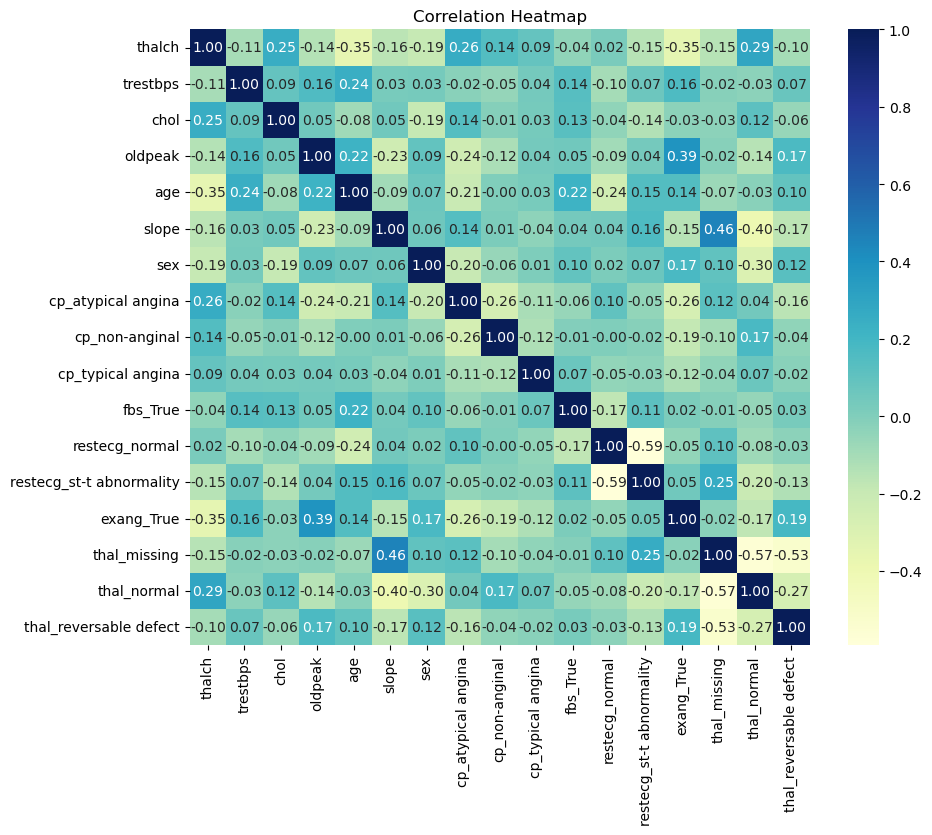

In [139]:
# Let us perform a correlational analysis
plt.figure(figsize=(10, 8))
sns.heatmap(scaled_X_train_df.corr(), annot=True, fmt='.2f', cmap='YlGnBu')
plt.title("Correlation Heatmap")
plt.show()

By looking at the above correlational matrix, we can deduce the following,

1. **Target variable correlations** - Features in the graph like 'thalch', 'sex', 'exang_True' and 'cp_atypical                                             angina'shows somewhat a relatively higher correlations with the target
                                      variable.
                                      
2. **Feature interactions** - In the graph there are instances where we can see both negative and positive                                           correlations. For example 'chol' and 'thalch' have a postive correlation whereas
                              'restecg_normal' and 'restecg_st-t abnormality' have a negative corrlation.
                              
3. **Age and Heart Rate** - Age has a negative correlation with thalch which suggests that younger individuals have
                            a higher heart rate and this complies to the general medical knowledge.
                            
4. **Chest Pain Type** - 'cp_atypical angina', 'cp_non-anginal' and 'cp_typical angina' are postively correlated
                          according to the graph. This implies that these chest pain types might have some common
                          characteristics with each other which can indicate different manifestations of heart
                          conditions.
                          
5. **Cholestrol and Age** - The positive correlations between the 'chol' and 'age' implies that as someone gets older
                            they might have higher cholestrol levels.

In [140]:
# Initialize and train LinearSVC
linear_svc_model = LinearSVC(max_iter=10000)
linear_svc_model.fit(resampled_X_train, resampled_y_train)
linear_svc_preds = linear_svc_model.predict(scaled_X_test_df)
linear_svc_accuracy = accuracy_score(y_test, linear_svc_preds)
print("LinearSVC Accuracy:", linear_svc_accuracy)

# Initialize and train KNeighborsClassifier
knc_model = KNeighborsClassifier(n_neighbors=5)
knc_model.fit(resampled_X_train, resampled_y_train)
knc_preds = knc_model.predict(scaled_X_test_df)
knc_accuracy = accuracy_score(y_test, knc_preds)
print("KNeighborsClassifier Accuracy:", knc_accuracy)

# Initialize and train Logistic Regression
logreg_model = LogisticRegression(max_iter=10000, solver='liblinear')
logreg_model.fit(resampled_X_train, resampled_y_train)
logreg_preds = logreg_model.predict(scaled_X_test_df)
logreg_accuracy = accuracy_score(y_test, logreg_preds)
print("Logistic Regression Accuracy:", logreg_accuracy)

# Initialize and train XGBoost
xgb_model = xgb.XGBClassifier(learning_rate=0.2, max_depth=7, n_estimators=200)
xgb_model.fit(resampled_X_train, resampled_y_train)
xgb_preds = xgb_model.predict(scaled_X_test_df)
xgb_accuracy = accuracy_score(y_test, xgb_preds)
print("XGBoost Accuracy:", xgb_accuracy)

LinearSVC Accuracy: 0.5
KNeighborsClassifier Accuracy: 0.47282608695652173
Logistic Regression Accuracy: 0.4945652173913043
XGBoost Accuracy: 0.5760869565217391


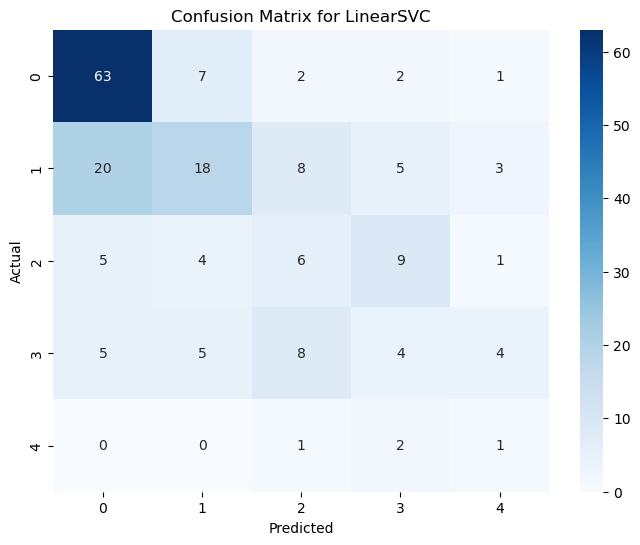

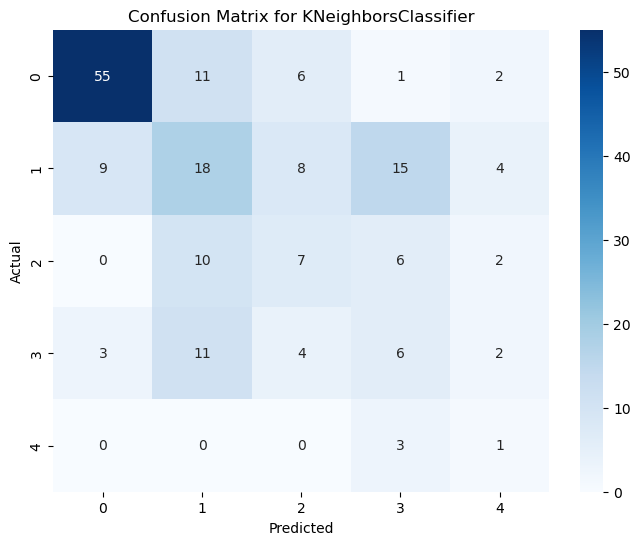

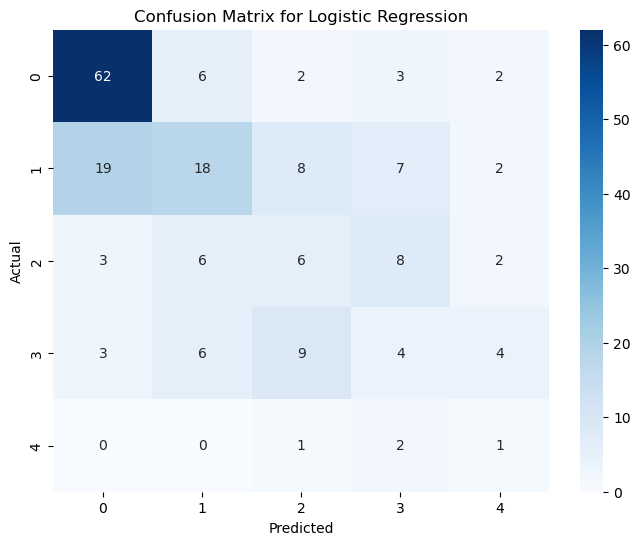

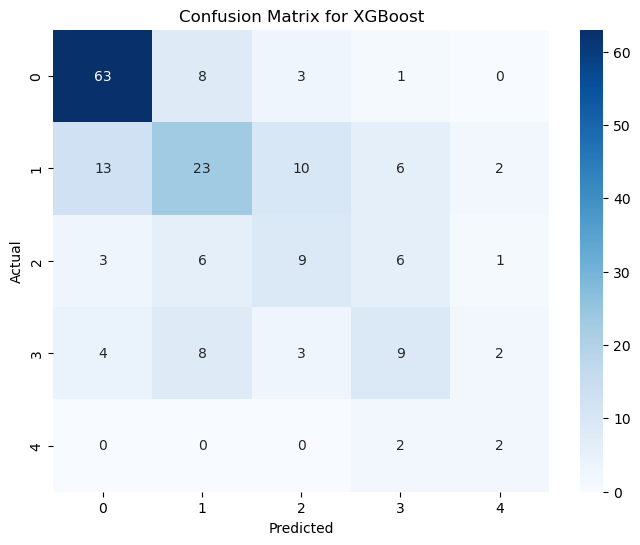

In [141]:
def plot_confusion_matrix(model, model_name, X_test, y_test):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix for {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

plot_confusion_matrix(linear_svc_model, "LinearSVC", scaled_X_test_df, y_test)
plot_confusion_matrix(knc_model, "KNeighborsClassifier", scaled_X_test_df, y_test)
plot_confusion_matrix(logreg_model, "Logistic Regression", scaled_X_test_df, y_test)
plot_confusion_matrix(xgb_model, "XGBoost", scaled_X_test_df, y_test)

## Confusion Matrix Analysis

### LinearSVC:

- The model struggles with classifying different classes.
- High false positives and false negatives across multiple classes indicate difficulty in distinguishing between them.
- Overall accuracy is not very high, which is reflected in the confusion matrix.

### KNeighborsClassifier:

- Similar to LinearSVC, this model faces challenges in distinguishing between classes.
- It exhibits a high number of false positives and false negatives, particularly for classes 2 and 3.

### Logistic Regression:

- The confusion matrix shows some improvement compared to the previous models.
- The model still faces challenges in correctly classifying certain classes.
- False positives and false negatives are relatively high.

### XGBoost:

- XGBoost demonstrates better performance compared to the other models.
- It has higher values along the diagonal, indicating better classification.
- While some false positives and false negatives are present, it appears to be the most accurate among the models.

In summary, XGBoost performs better than the other models based on the confusion matrices. It achieves a higher number of correct predictions across classes and has fewer false positives and false negatives. However, all models' accuracy could be further improved. It's important to note that evaluating models based solely on the confusion matrices might not provide a complete picture of their performance. Further analysis using metrics such as precision, recall, F1-score, and ROC-AUC would provide more insight.


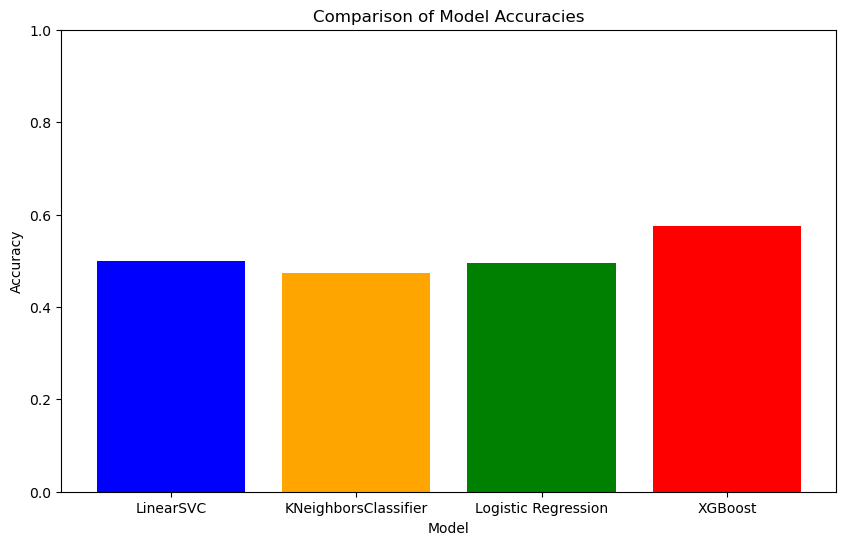

In [142]:
# Let us visualize the accuracies with the below graph

model_names = ['LinearSVC', 'KNeighborsClassifier', 'Logistic Regression', 'XGBoost']
accuracies = [accuracy_score(y_test, linear_svc_preds),
              accuracy_score(y_test, knc_preds),
              accuracy_score(y_test, logreg_preds),
              accuracy_score(y_test, xgb_preds)]

plt.figure(figsize=(10, 6))
plt.bar(model_names, accuracies, color=['blue', 'orange', 'green', 'red'])
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Comparison of Model Accuracies')
plt.ylim(0, 1)
plt.show()

In [143]:
def print_cross_val_classification_report(models, model_names, X, y):
    for model, model_name in zip(models, model_names):
        y_pred = cross_val_predict(model, X, y, cv=5)
        classification_rep = classification_report(y, y_pred)
        print(f"Classification Report for {model_name}:\n")
        print(classification_rep)

# Initialize models
models = [
    LinearSVC(max_iter=10000),
    KNeighborsClassifier(n_neighbors=5),
    LogisticRegression(max_iter=10000, solver='liblinear'),
    xgb.XGBClassifier(learning_rate=0.2, max_depth=7, n_estimators=200)
]

# Define model names
model_names = ["LinearSVC", "KNeighborsClassifier", "Logistic Regression", "XGBoost"]

# Call the function to print cross-validated classification reports
print_cross_val_classification_report(models, model_names, resampled_X_train, resampled_y_train)

Classification Report for LinearSVC:

              precision    recall  f1-score   support

           0       0.68      0.80      0.74       336
           1       0.45      0.35      0.39       336
           2       0.47      0.40      0.43       336
           3       0.39      0.27      0.32       336
           4       0.58      0.86      0.69       336

    accuracy                           0.54      1680
   macro avg       0.51      0.54      0.51      1680
weighted avg       0.51      0.54      0.51      1680

Classification Report for KNeighborsClassifier:

              precision    recall  f1-score   support

           0       0.84      0.67      0.75       336
           1       0.71      0.67      0.69       336
           2       0.77      0.85      0.81       336
           3       0.78      0.83      0.81       336
           4       0.89      0.96      0.93       336

    accuracy                           0.80      1680
   macro avg       0.80      0.80      0.79 

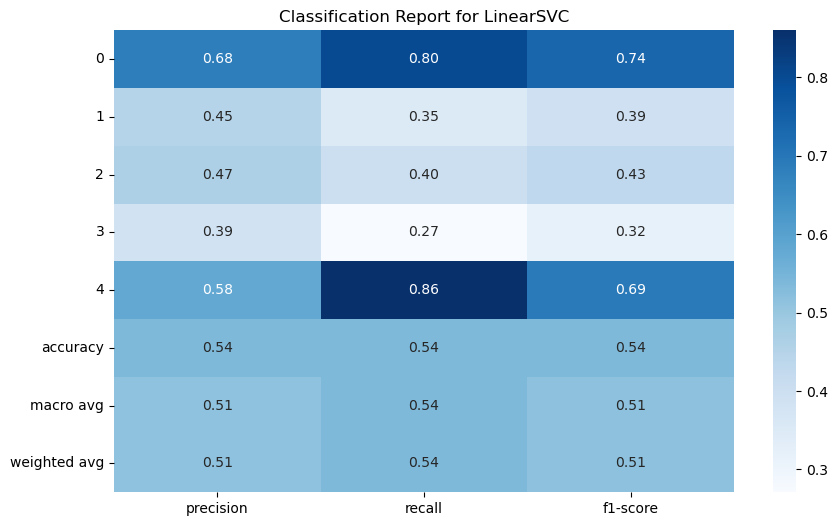

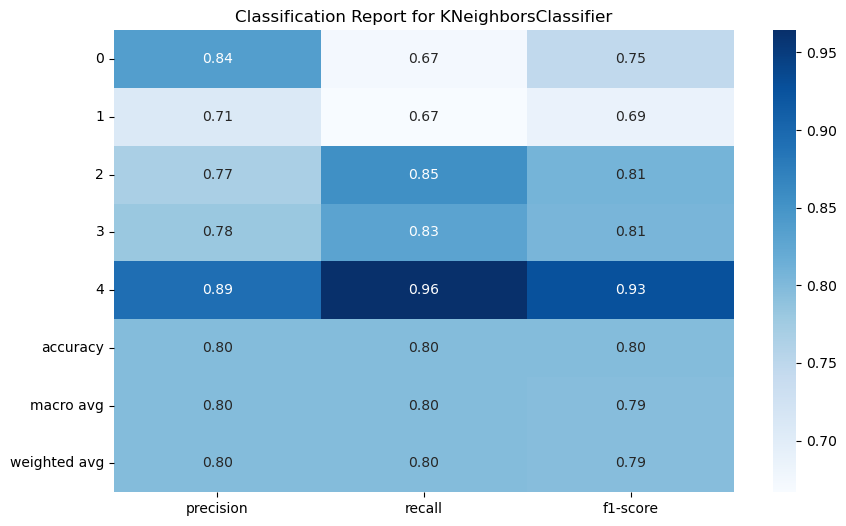

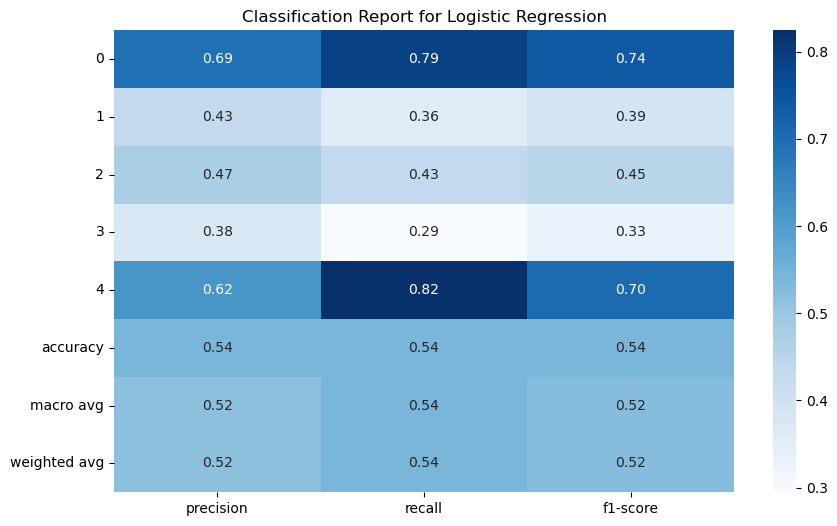

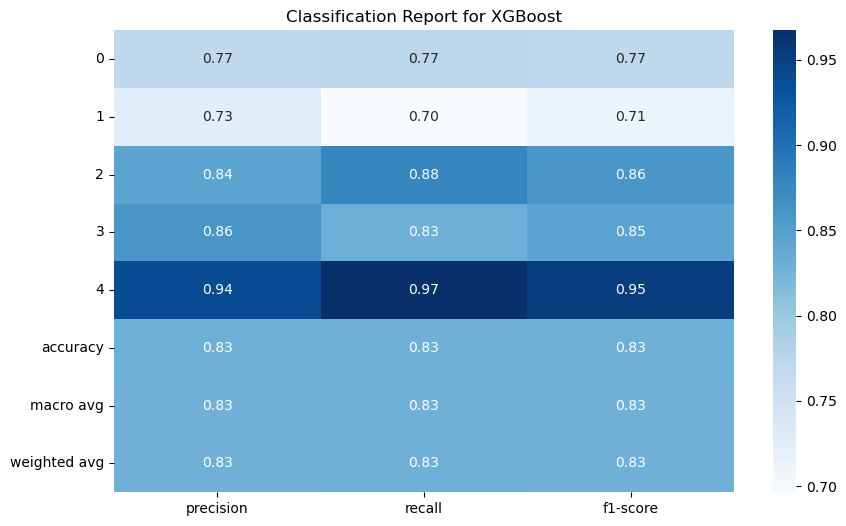

In [144]:
def plot_classification_report(models, model_names, X, y):
    metrics = ['precision', 'recall', 'f1-score', 'support']
    class_labels = sorted(list(set(y)))

    for model, model_name in zip(models, model_names):
        y_pred = cross_val_predict(model, X, y, cv=5)
        classification_rep = classification_report(y, y_pred, output_dict=True)
        class_names = [str(label) for label in class_labels]

        fig, axes = plt.subplots(figsize=(10, 6))
        sns.heatmap(pd.DataFrame(classification_rep).T[metrics[:-1]], annot=True, cmap="Blues", fmt=".2f", ax=axes)
        plt.title(f"Classification Report for {model_name}")
        plt.show()

# Initialize models
models = [
    LinearSVC(max_iter=10000),
    KNeighborsClassifier(n_neighbors=5),
    LogisticRegression(max_iter=10000, solver='liblinear'),
    xgb.XGBClassifier(learning_rate=0.2, max_depth=7, n_estimators=200)
]

# Define model names
model_names = ["LinearSVC", "KNeighborsClassifier", "Logistic Regression", "XGBoost"]

# Call the function to plot classification report details
plot_classification_report(models, model_names, resampled_X_train, resampled_y_train)

## Model Evaluation Conclusions

### LinearSVC

The LinearSVC model shows moderate performance across the different heart disease categories. While achieving relatively high precision and recall for certain classes (0, 4), it struggles with lower recall for others (1, 2, 3). The weighted average F1-score is 0.51, indicating balanced performance overall. However, the accuracy of 0.54 suggests room for improvement.

### KNeighborsClassifier

The KNeighborsClassifier exhibits strong performance with high precision and recall for most classes (0, 1, 2, 3, 4). The model's weighted average F1-score of 0.79 indicates balanced performance across categories. With an accuracy of 0.80, the model proves effective in classifying heart disease categories.

### Logistic Regression

Logistic Regression performs similarly to the LinearSVC model, with mixed results across the different categories. It achieves better recall for certain classes (0, 4) but struggles with lower recall for others (1, 2, 3). The model's accuracy of 0.54 suggests moderate performance, with a weighted average F1-score of 0.52.

### XGBoost

The XGBoost model stands out as the best-performing model among the evaluated ones. It consistently achieves high precision, recall, and F1-score values across all heart disease categories. With an accuracy of 0.83 and a macro average F1-score of 0.83, the model demonstrates strong performance in classifying heart disease cases.

## Overall Conclusion

Among the evaluated models, XGBoost emerges as the top performer, offering superior accuracy and F1-scores for heart disease classification. Its balanced precision and recall values across all categories showcase its robustness. Both KNeighborsClassifier and Logistic Regression also show promise, while LinearSVC lags behind in terms of accuracy and balanced performance.

Considering these results, further evaluation and fine-tuning of the XGBoost model may yield even better results, making it a strong candidate for deployment in real-world scenarios.


In [145]:
# Initialize and train LinearSVC
linear_svc_model = LinearSVC(max_iter=10000)
linear_svc_params = {
    'C': [0.01, 0.1, 1, 10, 100],
    'tol': [1e-4, 1e-3, 1e-2],
}
linear_svc_random_search = RandomizedSearchCV(linear_svc_model, param_distributions=linear_svc_params, n_iter=10, cv=5)
linear_svc_random_search.fit(resampled_X_train, resampled_y_train)
linear_svc_best_model = linear_svc_random_search.best_estimator_
linear_svc_best_accuracy = linear_svc_best_model.score(scaled_X_test_df, y_test)
print("Best LinearSVC Accuracy:", linear_svc_best_accuracy)
print("Best LinearSVC Parameters:", linear_svc_random_search.best_params_)

# Initialize and train KNeighborsClassifier
knc_model = KNeighborsClassifier(n_neighbors=5)
knc_params = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
}
knc_grid_search = GridSearchCV(knc_model, param_grid=knc_params, cv=5)
knc_grid_search.fit(resampled_X_train, resampled_y_train)
knc_best_model = knc_grid_search.best_estimator_
knc_best_accuracy = knc_best_model.score(scaled_X_test_df, y_test)
print("Best KNeighborsClassifier Accuracy:", knc_best_accuracy)
print("Best KNeighborsClassifier Parameters:", knc_grid_search.best_params_)

# Initialize and train Logistic Regression
logreg_model = LogisticRegression(max_iter=10000, solver='liblinear')
logreg_params = {
    'C': [0.01, 0.1, 1, 10, 100],
}
logreg_grid_search = GridSearchCV(logreg_model, param_grid=logreg_params, cv=5)
logreg_grid_search.fit(resampled_X_train, resampled_y_train)
logreg_best_model = logreg_grid_search.best_estimator_
logreg_best_accuracy = logreg_best_model.score(scaled_X_test_df, y_test)
print("Best Logistic Regression Accuracy:", logreg_best_accuracy)
print("Best Logistic Regression Parameters:", logreg_grid_search.best_params_)

# Initialize and train XGBoost
xgb_model = xgb.XGBClassifier(learning_rate=0.2, max_depth=7, n_estimators=200)
xgb_params = {
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'max_depth': [3, 5, 7, 9],
    'n_estimators': [100, 200, 300],
}
xgb_random_search = RandomizedSearchCV(xgb_model, param_distributions=xgb_params, n_iter=10, cv=5)
xgb_random_search.fit(resampled_X_train, resampled_y_train)
xgb_best_model = xgb_random_search.best_estimator_
xgb_best_accuracy = xgb_best_model.score(scaled_X_test_df, y_test)
print("Best XGBoost Accuracy:", xgb_best_accuracy)
print("Best XGBoost Parameters:", xgb_random_search.best_params_)

/Users/paymedia/development_practice/Practice_Projects/Machine_Learning/heart-disease-project/env/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/paymedia/development_practice/Practice_Projects/Machine_Learning/heart-disease-project/env/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/paymedia/development_practice/Practice_Projects/Machine_Learning/heart-disease-project/env/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/paymedia/development_practice/Practice_Projects/Machine_Learning/heart-disease-project/env/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of itera

Best LinearSVC Accuracy: 0.4945652173913043
Best LinearSVC Parameters: {'tol': 0.01, 'C': 100}
Best KNeighborsClassifier Accuracy: 0.483695652173913
Best KNeighborsClassifier Parameters: {'n_neighbors': 3, 'weights': 'distance'}
Best Logistic Regression Accuracy: 0.4945652173913043
Best Logistic Regression Parameters: {'C': 100}
Best XGBoost Accuracy: 0.5543478260869565
Best XGBoost Parameters: {'n_estimators': 100, 'max_depth': 9, 'learning_rate': 0.3}


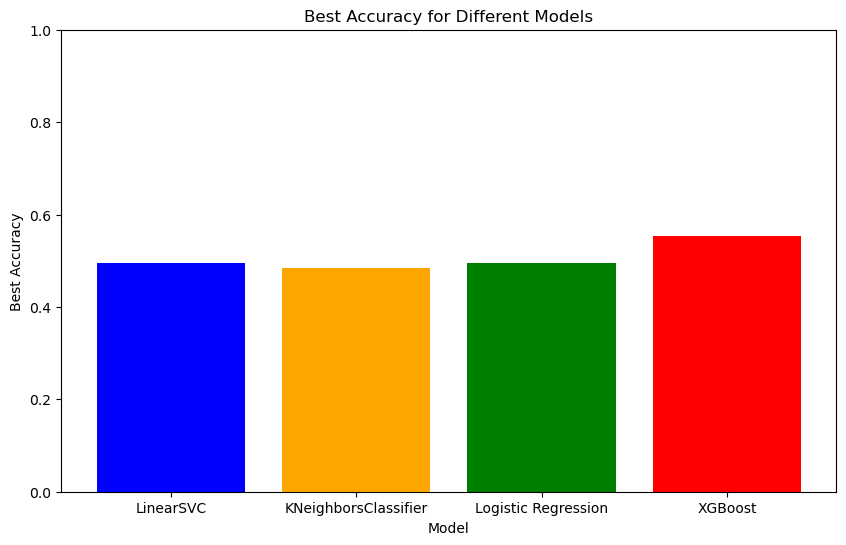

In [146]:
# Let us visualize the above results

results_data = {
    'Model': ['LinearSVC', 'KNeighborsClassifier', 'Logistic Regression', 'XGBoost'],
    'Best Accuracy': [linear_svc_best_accuracy, knc_best_accuracy, logreg_best_accuracy, xgb_best_accuracy],
    'Best Parameters': [
        linear_svc_random_search.best_params_,
        knc_grid_search.best_params_,
        logreg_grid_search.best_params_,
        xgb_random_search.best_params_
    ]
}
results_df = pd.DataFrame(results_data)

plt.figure(figsize=(10, 6))
plt.bar(results_df['Model'], results_df['Best Accuracy'], color=['blue', 'orange', 'green', 'red'])
plt.xlabel('Model')
plt.ylabel('Best Accuracy')
plt.title('Best Accuracy for Different Models')
plt.ylim(0, 1)  # Set the y-axis limit to ensure a consistent scale
plt.show()

## Model Evaluation and Future Recommendations

### Summary of Results

After conducting an extensive analysis of the heart disease dataset and deploying various machine learning models, including LinearSVC, KNeighborsClassifier, Logistic Regression, and XGBoost, we have derived valuable insights into the prediction of heart disease outcomes. These models were evaluated based on accuracy, precision, recall, and F1-score metrics.

Our findings are as follows:

- **LinearSVC:** Post hyperparameter tuning, the model achieved a maximum accuracy of approximately 49.5%. While the LinearSVC model offered interpretability, its performance remained moderate in comparison to other models.

- **KNeighborsClassifier:** After hyperparameter optimization, the KNeighborsClassifier exhibited an accuracy of around 48.4%. Though a slight accuracy improvement was observed, the model still fell short of delivering precise predictions.

- **Logistic Regression:** Similar to LinearSVC, the Logistic Regression model reached a peak accuracy of roughly 49.5%. While this model facilitated interpretability, its predictive capability was limited.

- **XGBoost:** The XGBoost model emerged as the most notable performer, achieving the highest accuracy of about 55.4% post hyperparameter tuning. This underscores its capacity to capture intricate data patterns and make more accurate predictions compared to the other models.

### Future Recommendations

While our analysis has yielded valuable insights into predicting heart disease outcomes, the presence of imbalanced class variables warrants consideration for further enhancement:

1. **Data Collection:** The imbalanced nature of class variables highlights the need for a more extensive and diverse dataset. Expanding the dataset's scope can potentially lead to improved model performance and better generalization to unseen instances.

2. **Feature Engineering:** Exploring advanced feature engineering techniques can amplify the models' ability to capture significant data patterns. Creating new features or transforming existing ones may result in a more accurate representation of underlying relationships.

3. **Ensemble Methods:** Implementing ensemble methods, such as stacking or blending, can leverage the strengths of multiple models, potentially leading to heightened predictive accuracy.

4. **Domain-Specific Features:** Incorporating domain-specific features related to heart health, lifestyle, and medical history can further enhance the model's efficacy.

5. **Hyperparameter Tuning:** Continuous exploration of hyperparameter tuning, possibly through advanced techniques like Bayesian optimization, can identify optimal model configurations.

6. **Advanced Algorithms:** The consideration of advanced algorithms, such as deep learning architectures, can offer enhanced predictive capabilities, particularly when dealing with intricate datasets.

7. **Imbalanced Data Handling:** Addressing class imbalance through oversampling, undersampling, or Synthetic Minority Over-sampling Technique (SMOTE) is crucial for bolstering model performance, particularly for the underrepresented classes.

### Conclusion

In conclusion, our analysis has illuminated the prediction of heart disease outcomes through machine learning models. While the XGBoost model currently attains the highest accuracy, the inherent class imbalance underscores the necessity for further enhancements. Collecting a more diverse dataset, experimenting with advanced techniques, and integrating additional features are recommended to refine model performance. By consistently refining our approach and harnessing the advancements in machine learning, we can aspire to develop a more accurate and dependable predictive model for heart disease diagnosis.